In [1]:
%pylab inline

import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
def get_detbias(dets,ells,cut,dcc,ind):
    """
    Parameters:
        dets: 	    detection array
        cut:        selection cut
        dcc:        bin size when estimating marginal density
        inds:       shifting indexes
    """
    assert len(dets)==len(ells)
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    ll     =  cut;uu  =  cut+dcc
    msk    =  (dets[fnmv]>ll)&(dets[fnmv]<uu)
    cor1=np.sum(ells[fnmr1][msk])/dcc
    cor2=np.sum(ells[fnmr2][msk])/dcc
    return cor1,cor2

In [3]:
# merge data from n fields
out1=[]
out2=[]
for _i in range(500):
    _a1=fitsio.read('../../../sim/src_basicCenter-var0em0/psf60/fpfs-cut16-%04d-g1-0000.fits' %_i)
    _a2=fitsio.read('../../../sim/src_basicCenter-var0em0/psf60/fpfs-cut16-%04d-g1-2222.fits' %_i)
    out1.append(_a1)
    out2.append(_a2)
out1 =   rfn.stack_arrays(out1,usemask=False)
out2 =   rfn.stack_arrays(out2,usemask=False)
gc.collect()

6

In [4]:
out1 =   rfn.stack_arrays(out1,usemask=False)
out2 =   rfn.stack_arrays(out2,usemask=False)

outD1=   pdet.peak2det(out1)
outE1=   pdet.fpfsM2E(out1,outD1,const=2000)
outEU1=  pdet.fpfsM2E(out1,const=2000)
outD2=   pdet.peak2det(out2)
outE2=   pdet.fpfsM2E(out2,outD2,const=2000)
outEU2=  pdet.fpfsM2E(out2,const=2000)

del out1,out2
gc.collect()

0

In [8]:
dcc=0.01
x=[]
y1=[]
y2=[]
tt=(2,2)
pn='v%d%d' %tt

if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
else:
    xlabel=r'$I_{\rm peak}$'
for i in range(0,10):
    cut=0.2*i
    
    msk1 = (outD1['pdet_%s' %pn]>cut)
    ellM1= outE1[msk1]
    detM1= outD1[msk1]
    del msk1
    
    msk2 = (outD2['pdet_%s' %pn]>cut)
    ellM2= outE2[msk2]
    detM2= outD2[msk2]
    del msk2
    
    cor1 = get_detbias(detM1,ellM1,cut,dcc,ind=tt)[0]
    cor2 = get_detbias(detM2,ellM2,cut,dcc,ind=tt)[0]
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    print(cor1)
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del ellM1,detM1,ellM2,detM2
gc.collect()

0.0
12457.732147910674
28352.172531190274
28051.670368963594
27817.898190682132
20169.182875579598
18981.273747918014
17654.06445010164
12807.027260346093
16111.287558292634


5838

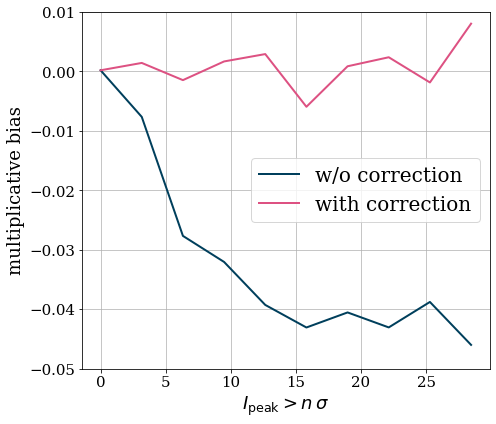

In [9]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.01)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

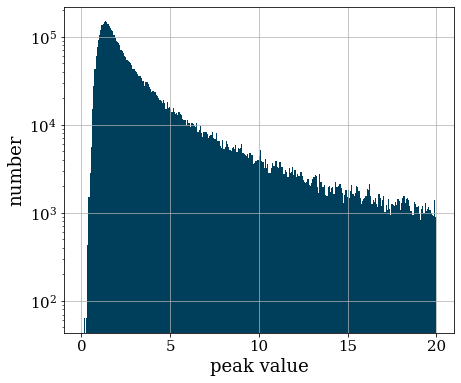

In [11]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.hist(outD1['pdet_v22']/0.2,range=(0,20),bins=300,color=pltutil.colors[0])
ax.set_yscale('log')
ax.set_xlabel('peak value')
ax.set_ylabel('number')
ax.grid()